In [1]:
#data and reps from here:
#https://github.com/henanjun/LCMR/blob/1/LCMR/LCMR_demo.m

#demo for LCMR to be appeared TGRS if you use code, please kind cite the paper, "A New Spatial-Spectral Feature Extraction Method for Hyperspectral Images Using Local Covariance Matrix Representation" Leyuan Fang et al. to be appeared TGRS

import sys
sys.path.append('./Hands')
from hand_utils import *
sys.path.append('./scripts')
import flag_dimensionality_reduction as fdr
from utils import *

from itertools import compress

from matplotlib import pyplot as plt
from geomstats.geometry.pre_shape import PreShapeSpace



class GeomstatsShapeSpace():
    """A simple adapter class which uses pymanopt language for geomstats shape space
    """

    def __init__(self, n, k):
        self._man = PreShapeSpace(m_ambient = n, k_landmarks = k)
        self._man.equip_with_group_action("rotations")
        self._man.equip_with_quotient_structure()

    def dist(self, point_a, point_b):
        return self._man.metric.dist(point_a, point_b)

    def exp(self, base_point, tangent_vector):
        return self._man.metric.exp(tangent_vector, base_point=base_point)

    def log(self, base_point, ambient_point):
        return self._man.to_tangent(ambient_point, base_point=base_point)
    
    def random_point(self):
        return self._man.random_point()


INFO: Using numpy backend


# Generate dataset with 40 hands and 30 ellipse outliers

In [2]:
n_outs  = 16

n_ins = 44-n_outs

trial = 4
        

# load data
filepath = './Hands/all/shapes'
segmentationlist = readSegmentations(filepath,getxy)[0]
hands0 = np.array(segmentationlist).T
hands = procrustes_hand(hands0)

np.random.seed(trial)
in_ids = np.random.choice(40, n_ins, replace = False)

shapes = []
for i in in_ids:
    h = hands[i]
    k_shape = unmake_1d(h)
    k_shape = k_shape - np.mean(k_shape, axis = 0)
    k_shape = k_shape/np.linalg.norm(k_shape)
    shapes.append(k_shape)

for i in range(n_outs):
    outlier = generate_ellipse_outlier(i + 10*trial)
    shapes.append(outlier)

labels = [0]*n_ins + [1]*n_outs

# Flagified Robust PCA Variant

We compute fWPCA on flattened hand data contaminated with 30 outliers. Then plot the objective function values and distance on the flag manifold between consecutive iterates of Algorithm 1 in the paper.

--------------------
iteration 0
objective 62.81316137206901
flag distance between B0 and B1 1.4069534253839138

--------------------
iteration 1
objective 62.571114576496434
flag distance between B0 and B1 0.09890172447063945

--------------------
iteration 2
objective 62.53129605507033
flag distance between B0 and B1 0.033697020748671765

--------------------
iteration 3
objective 62.493209479323426
flag distance between B0 and B1 0.03375114642536206

--------------------
iteration 4
objective 62.431961160925425
flag distance between B0 and B1 0.04064073600277465

--------------------
iteration 5
objective 62.33107322811124
flag distance between B0 and B1 0.04955870439189207

--------------------
iteration 6
objective 62.18164954890277
flag distance between B0 and B1 0.05739065905849899

--------------------
iteration 7
objective 62.01924219332953
flag distance between B0 and B1 0.0580226432465542

--------------------
iteration 8
objective 61.922901864120796
flag distance between B0

Text(0.5, 1.0, 'Distance Between Iterates')

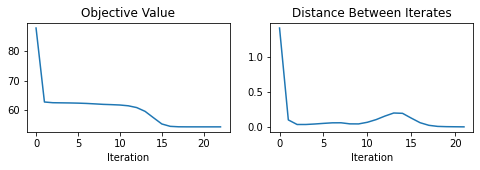

In [3]:
flat_data = np.vstack([d.flatten() for d in shapes]).T #features (random variables) are rows and points (samples) are columns

W_fpca, errs, cauchs   = fdr.flag_robust_pca(   flat_data,          # data set in R^n
                                                [1,2],              # flag type (nested subspace dimensions in increasing order)
                                                'wpca',             # robust pca variant (wpca, rpca, or dpcp)
                                                max_iters = 200,    # max number of irls itertions
                                                init= 'rand',       # initialization type
                                                verbose = True,     # print progress at each iteration
                                                return_all = True)  # return more than the principal directions?


# plot results
fig, [ax1, ax2] = plt.subplots(1,2, figsize = (8,2))

ax1.plot(errs)
ax1.set_xlabel('Iteration')
ax1.set_title('Objective Value')

ax2.plot(cauchs)
ax2.set_xlabel('Iteration')
ax2.set_title('Distance Between Iterates')

# Compare Flagified PCA variant to TPCA

In [4]:
manifold = GeomstatsShapeSpace(2,56) #initialize kendall shape space
fl_type = [1,2] #choose flag type

In [5]:
#compute karcher median (for fWTPCA, fRTPCA, or fTDPCP)
mean_seed = 21
median = fdr.karcher_median(manifold, shapes, seed = mean_seed)

In [6]:
#run flagified tangent dpcp
[W_ftpca,_,_], ts_ftpca = fdr.flag_robust_tpca( manifold,            #the pymanopt manifold
                                                shapes,              #data as points on the manifold
                                                fl_type = fl_type,   #the flag type
                                                pca_type = 'dpcp',   #the PCA variant (wpca, rpca, or dpcp)
                                                return_ts = True,    #return the dataset and tangents to the median
                                                median = median,     #the karcher median
                                                init = 'svd')        #initialization choice: svd, random, etc...

In [7]:
#run tpca
W_tpca, _, ts_tpca, mean =  PGA0(manifold,         #manifold as pymanopt object
                                shapes,           #data
                                [fl_type[-1]],    #number of PDs
                                return_ts = True, #return the dataset and tangents to the karcher mean
                                eps = 1e-9)       #convergence parameter for karcher mean

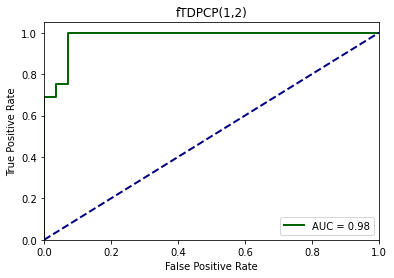

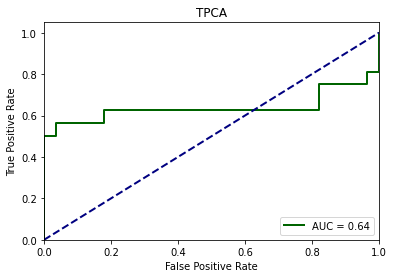

In [8]:
#plot fTDPCP ROC curve for outlier detection
plt.title('fTDPCP(1,2)')
auc_ftpca, preds_ftpca, thresh_ftpca  = run_roc(shapes, W_ftpca, labels, 'dpcp', manifold, ts_ftpca, median, do_plots = True)

#plot TPCA ROC curve
plt.title('TPCA')
auc_tpca,  preds_tpca,  thresh_tpca  = run_roc(shapes, W_tpca, labels, 'pca', manifold, ts_tpca, mean, do_plots = True)

In [9]:
#remove the detected outliers

#boolean array with predicted inliers as True
tpca_inlier_idx = preds_tpca <  thresh_tpca
ftpca_inlier_idx = preds_ftpca < thresh_ftpca

#Find the index of inliers predicted by both methods (useful for reconstruction indexing later...)
true_vals = np.vstack([tpca_inlier_idx, ftpca_inlier_idx])
hands_in_all_idx = np.where(np.sum(true_vals, axis = 0)> 0)[0]

#collect predicted inliers for each method
ftpca_shapes = list(compress(shapes, ftpca_inlier_idx))
tpca_shapes = list(compress(shapes, tpca_inlier_idx))



In [10]:
# recontruct inlier hands

#run tpca to reconstruct inlier hands
W_rec_ftpca, _, ts_rec_ftpca, mean_rec_ftpca =  PGA0( manifold, ftpca_shapes, [fl_type[-1]], return_ts = True, eps = 1e-9 )
W_rec_tpca, _, ts_rec_tpca, mean_rec_tpca =  PGA0( manifold, tpca_shapes, [fl_type[-1]], return_ts = True, eps = 1e-9 )

#compute hand reconstructions
err_ftpca, rec_data_ftpca  = reconst_class_man(manifold, mean_rec_ftpca, ftpca_shapes, ts_rec_ftpca, W_rec_ftpca, return_data= True)
err_tpca, rec_data_tpca  = reconst_class_man(manifold, mean_rec_tpca, tpca_shapes, ts_rec_tpca, W_rec_tpca, return_data= True)





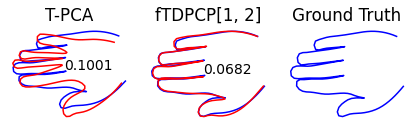

In [13]:
#choose to plot the reconstruction of hand number 2
to_reconstr_idx = hands_in_all_idx[2]
ftpca_id = np.sum(ftpca_inlier_idx[:to_reconstr_idx])
tpca_id = np.sum(tpca_inlier_idx[:to_reconstr_idx])


#make the plots
W=256
H=256

plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1,3, figsize = (6,2))

axs = axs.flatten()

interp_points = interp(shapes[to_reconstr_idx])
axs[2].plot(interp_points[0]*W,interp_points[1]*H, c = 'b')
axs[2].set_title('Ground Truth')
axs[2].axis('off')

interp_points = interp(shapes[to_reconstr_idx])
axs[0].plot(interp_points[0]*W,interp_points[1]*H, c = 'b')
interp_points = interp(rec_data_tpca[tpca_id])
axs[0].plot(interp_points[0]*W,interp_points[1]*H, c = 'r')
axs[0].text(13,-2,np.round(err_tpca[to_reconstr_idx],4))
axs[0].axis('off')
axs[0].set_title(f'T-PCA')

interp_points = interp(shapes[to_reconstr_idx])
axs[1].plot(interp_points[0]*W,interp_points[1]*H, c = 'b')
interp_points = interp(rec_data_ftpca[ftpca_id])
axs[1].plot(interp_points[0]*W,interp_points[1]*H, c = 'r')
axs[1].text(13,-2,np.round(err_ftpca[to_reconstr_idx],4))
axs[1].axis('off')
axs[1].set_title(f'fTDPCP{fl_type}')
        
plt.tight_layout()

